<a href="https://colab.research.google.com/github/22Ifeoma22/22Ifeoma22/blob/main/Copy_of_Exercise_Autooff_Agorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the torch package and matplotlib for graphics
## Explained using Multivariate Linear Regression in Pytorch and Python

Distributied Gradient Descent
in this notebook,you can learn about


*   gradient descent with gradient accumulation
*   deep learning with training datasets that do not fit in node memory
*   gradient accumulation in parameter servser-based vs ring-based(for example Horovod)gradient descent
*   Reduce-Scater and reduce-all phases in Horovod
*   Horovod as an implementation for distributed data parallel training in deep learning

Why shouldwe care? Are you:


*   Informing deep learning platform buy vs. build decision for your project, team, or organisation
*   Scaling up your deep learning models to out-of-memory training datasets
*   Understanding of troubleshooting distributed deep learning training
*   researching the direction of high performance distributed deep learning
*   working on federated deep learning or bandwidth-constrained(IOT)training at cloud's edge
This notenbook builds on the gradient descent, differentiation, tensors, and other concepts introduced in


*   Automatic Differentiation Explained
*   Bandwidth Optimal All-reduce Algorithms
*   Bring HPC Techniques to Deep learning


In [ ]:
import torch as pt
%matplotlib inline
import matplotlib as plt
import numpy as np
import pandas as pd

SEED = 42
pt.manual_seed(SEED)
np.random.seed(SEED)

pt.__version__, np.__version__, pd.__version__ # Use __version__ (lowercase v) to access version

('2.3.1+cu121', '1.25.2', '2.0.3')

#Create a training dataset of features for multivariate linear regreassion



*   TRAINING_DATASET_SIZE is pre-set to a default of 1,000
* Assume that FEATURES is set to 4  



In [ ]:
TRAINING_DATASET_SIZE = 1000
FEATURES = 4

Create a NumPy nd-array named x_numpy with a shape of (TRAINING_DATASET_SIZE, FEATURES):
*   The array should contain features values shuch that the values in each column are from a normal
(bell-shaped) distribution.
*   The means of the features values should be 0.0 for the first column, 1.0 for the second column, and so on.
*   The feature values across columns should be uncorrelated.

 **HINT**:You can use np.random.multivariate_normal to create x_numpy





In [ ]:
X_numpy = np.random.multivariate_normal(np.arange(FEATURES), np.eye(FEATURES), TRAINING_DATASET_SIZE )
X_numpy

array([[ 0.49671415,  0.8617357 ,  2.64768854,  4.52302986],
       [-0.23415337,  0.76586304,  3.57921282,  3.76743473],
       [-0.46947439,  1.54256004,  1.53658231,  2.53427025],
       ...,
       [ 1.92344579,  0.22538503,  0.31081696,  2.52873626],
       [-1.97548777,  1.75109945, -0.06508305,  3.02845758],
       [-2.07781182,  0.6797022 ,  3.64337816,  3.36064789]])

#Check that a column's feature values are normal
Hint: You can use the matplotlib.pyplot.hist Method.

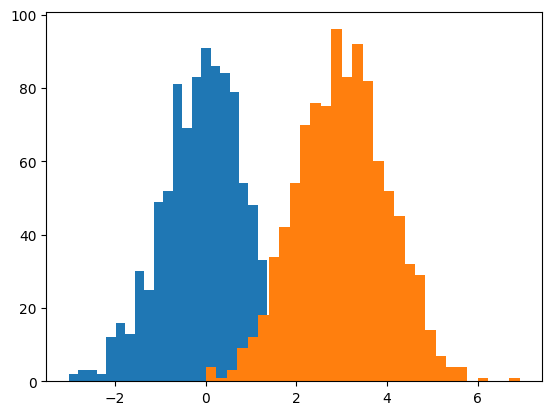

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code)

plt.hist(X_numpy[:, 0], bins=30)  # Removed semicolon, which isn't necessary here
plt.hist(X_numpy[:, 3], bins=30)
plt.show()

#Confirm that the feature values are incorrelated across columns
**Hint**: You can see the pandas.DataFrame.corr method

In [ ]:
pd.DataFrame(X_numpy).corr()

,0,1,2,3
0,1.000000,0.008146,-0.038208,-0.022976
1,0.008146,1.000000,-0.032355,0.004602
2,-0.038208,-0.032355,1.000000,0.033745
3,-0.022976,0.004602,0.033745,1.000000


#Create a PyTorch tensor X_train from X_numpy

*  You can use PyTorch's from_numpy function to resue the in-memory data allocated by a NumPy nd-array

* Ensure that the resulting PyTorch tensor has a shape of (Training_Dataset_size,FEATURES)



In [ ]:
X_train = pt.tensor(X_numpy,dtype=pt.float64).reshape(TRAINING_DATASET_SIZE, FEATURES)
X_train

tensor([[ 0.4967,  0.8617,  2.6477,  4.5230],
        [-0.2342,  0.7659,  3.5792,  3.7674],
        [-0.4695,  1.5426,  1.5366,  2.5343],
        ...,
        [ 1.9234,  0.2254,  0.3108,  2.5287],
        [-1.9755,  1.7511, -0.0651,  3.0285],
        [-2.0778,  0.6797,  3.6434,  3.3606]], dtype=torch.float64)

Note that the COEFFICIENTS tensor is pre-defined as [5, 3, 2, 1] just to make the linear regression easier to visualize in the upcoming cells

In [ ]:
COEFFICIENTS = pt.tensor([5, 3, 2, 1])
COEFFICIENTS

tensor([5, 3, 2, 1])

Create a y_train tensor using COEFFICIENTS and X_train

Gradient descent will atempt to recover the COEFFICIENTS and X_train

Gradient descesnt will ateempt to recover the COEFFICIENS using just the y_train and X_train values.
*   Ensure that y_train has a shape of (TRAINING_DATASET_SIZE)
*   



In [ ]:
# Convert COEFFICIENTS to have the same type as X_train
COEFFICIENTS = COEFFICIENTS.double()

# Perform the matrix multiplication
y_train = X_train @ COEFFICIENTS
y_train = y_train.reshape(TRAINING_DATASET_SIZE)
y_train


tensor([ 1.4887e+01,  1.2053e+01,  7.8877e+00,  1.4578e+00,  2.6502e+00,
         1.5361e+01,  5.6846e+00,  6.7706e+00,  7.1836e+00,  2.7058e+00,
         1.3674e+01,  5.8370e-01,  6.6921e+00,  1.1444e+01,  6.5143e+00,
         3.6383e+00,  1.8991e+01,  1.2134e+01,  1.0097e+01,  7.7342e+00,
         1.2410e+01,  6.6118e+00,  1.0054e+01,  3.2590e+00,  1.2039e+01,
         1.7350e-01,  1.4353e+01,  7.2004e+00,  1.7608e+01,  9.3580e+00,
         1.2631e+01,  1.6958e+01,  5.9551e+00,  5.8203e+00,  5.5137e+00,
         1.2028e+01,  9.8505e+00,  1.4348e+01,  7.1684e+00,  1.9024e+01,
         8.9844e+00,  1.9596e+01,  3.9170e+00,  1.2019e+01,  1.6616e+01,
         8.8976e+00,  1.1898e+01,  1.1849e+00,  8.0649e+00,  5.0153e+00,
         1.6691e+01,  1.8420e+00,  2.6411e+01,  1.6853e+01,  4.5366e+00,
         1.5731e+01,  9.9580e+00,  7.2180e+00,  1.3195e+01, -3.7490e-02,
         7.5689e+00,  1.3918e+00,  1.8438e+01,  2.0185e+01,  1.5874e+01,
        -2.3202e+00,  6.8285e+00,  9.6387e+00,  1.4

#Visualize the 5 dimensions of the linear regression problem

Use the scatter plot to visualise the 4 dimensions of the X_train as 3 spatial and 1 size dimensions.The 1 dimension of y_train is visualiszed as the color on the scatter plot.

*   The scale setting is configure to 1,000 for a better looking visualisation and does not change the original multivariate linear regression problem.

*   The stride setting is configured to 25 by default.You can choose more data points out of TRAINING_DATASET_SIZE to visualize by setting STRIDE to be closer to 1, or fewer data points to visulze by using a Stride value closer to TRAINING_DATASET_SIZE.



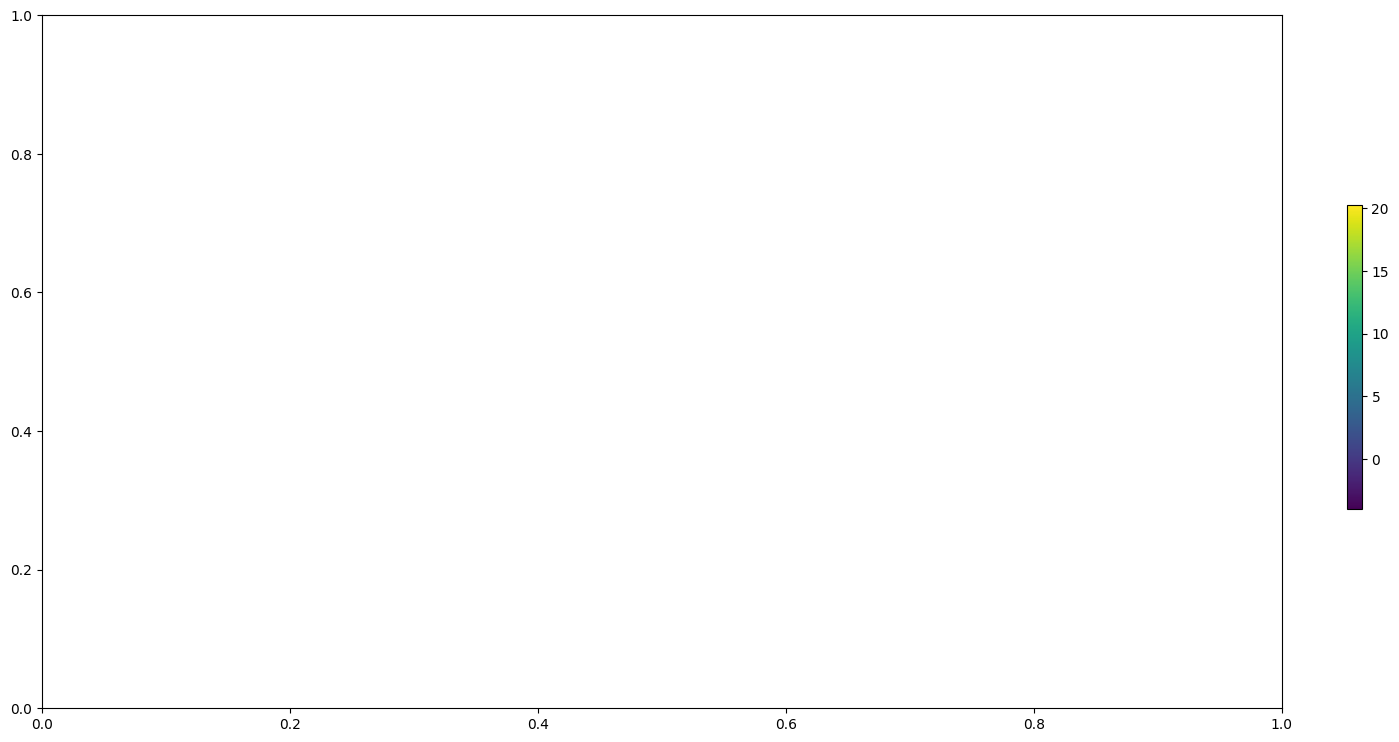

In [ ]:
%matplotlib  inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

figure = plt.figure(figsize = (16, 9))
axis = Axes3D(figure, rect = [0, 0, .95, 1], elev=48, azim=134)

SCALE = 1_000
y_view, X_view = SCALE * y_train, SCALE * X_train

STRIDE = 25
pc = axis.scatter(X_view[::STRIDE, 0], X_view[::STRIDE, 1], X_view[::STRIDE, 2], s = X_view[::STRIDE, 3], c = y_train[::STRIDE])
figure.colorbar(pc, fraction = 0.01)
axis.set_xlabel('x0'), axis.set_ylabel('x1'), axis.set_zlabel('x2');
plt.show()


#Create random values for the initial model parameters
*   create a w_numpy nd-array shaped (FEATURES, 1) with the model parameter values
*   You can use normally distributed randn values or try a more complex initialization scheme



In [ ]:
w_numpy = np.random.randn(FEATURES, 1)
w_numpy

array([[-0.8634936 ],
       [-0.03120349],
       [ 0.01801687],
       [ 0.47263035]])

#Instantiate a differentiable tensor w as the model

- the w tensor should use w_numpy and use pt.float64 as the dtype
- recall that requires_grad must be True for a PyTorch tensor to be differentiable
- You can use torch.randn to initialize the values or try a more complex scheme like torch.nn.init.kaiming_uniform_
- implement the forward and mse functions for the model

In [ ]:
w = pt.tensor(w_numpy, requires_grad=True, dtype=pt.float64)
w

def forward (w, X):
  return (X @ w).reshape(X.shape[0])

def mse(y_est, y):
  err = y_est - y
  return(err**2).mean()

mse(forward(w, X_train), y_train)

tensor(122.5371, dtype=torch.float64, grad_fn=<MeanBackward0>)

#Solve for the cofficients using ordinary gradient descent
For consistency, with the upcoming parts of the notebook use
- EPOCHS = 400
- LEARNING_RATE = 0.01

In [ ]:
EPOCHS = 400
LEARNING_RATE = 0.01

Recover the cofficients from the data using ordinary gradient descent
- the entire training dataset is used to compute the gradients per iteration of gradient descent


In [ ]:
for epoch in range(EPOCHS):
  y_est = forward(w, X_train)
  loss = mse(y_est, y_train)
  loss.backward()

  w.data -= LEARNING_RATE * w.grad
  w.grad = None

w.data

tensor([[4.9967],
        [2.9996],
        [1.9992],
        [1.0007]], dtype=torch.float64)

What if the training dataset dosen't fit in -memory of the node?

Gradient Descent using Gradient Accumulation

- Single node, in-memory implementation
- For example, an in- memory shard(a part of the training dataset) can consist of 250 training examples.


Training            Shared Model   Los Function Sequencial
Datasets            Parameters      Gradients
Shards               (Weights)

          

[0   :250]o  ------>     --------> g 0              sequential Gradient
[250:500]1  ------->  w  -------> g 1 + g0          Accumulation
[500:750]2 -------->     --------> g2 + g1 + g0
[750:]3 ----------->     ---------> (g3 +g2 + g1 + g0)
w -=LEARNING_RATE *(g3 + g2 + g1 + g0)

In [ ]:
IN_MEORY_SHARD_SIZE = 250
w = pt.tensor(w_numpy, requires_grad=True, dtype=pt.float64)
from torch.utils.data import TensorDataset,DataLoader

Single node gradient descent with gradient accumulation
- use TensorDataset and DataLoader from the torch.utils.data package
- Use IN_MEMORY_SHARD_SIZE / TRAINING_DATASET_SIZE to ajust the loss function for the shard size
- Demonstrate gradient accumulation vs mini-batch gradient descent explaining shards vs training vs training batches.

IN_MEMORY_SHARD_SIZE = 250 # Define the variable here
LEARNING_RATE = 0.01 # Define the learning rate

training_ds = TensorDataset(y_train, X_train) # Define the TensorDataset
train_d1 = DataLoader(training_ds, batch_size=IN_MEMORY_SHARD_SIZE, shuffle=False) #use shuffle=True

for epoch in range(EPOCHS):
  for y_shard, X_shard in train_d1:
    y_est = forward(w, X_shard)
    loss = (IN_MEMORY_SHARD_SIZE / TRAINING_DATASET_SIZE) * ((y_est -  y_shard) **2).sum() * (1/ IN_MEMORY_SHARD_SIZE)
    loss.backward()
    w.data -= LEARNING_RATE *  w.grad # Use the correct variable name here
    w.grad = None

In [ ]:
IN_MEMORY_SHARD_SIZE = 250 # Define the variable here
LEARNING_RATE = 0.01 # Define the learning rate

training_ds = TensorDataset(y_train, X_train) # Define the TensorDataset
train_d1 = DataLoader(training_ds, batch_size=IN_MEMORY_SHARD_SIZE, shuffle=False) #use shuffle=True

for epoch in range(EPOCHS):
  for y_shard, X_shard in train_d1:
    y_est = forward(w, X_shard)
    loss = mse(y_est, y_shard)
    loss.backward()
    w.data -= LEARNING_RATE *  w.grad # Use the correct variable name here
    w.grad = None

In [ ]:
w.data

tensor([[5.0000],
        [3.0000],
        [2.0000],
        [1.0000]], dtype=torch.float64)

Can gradient accumulation help distribute gradient descent?
## Parameter server-based distributed (multi-node) gradient descent



In [ ]:
NODES = TRAINING_DATASET_SIZE // IN_MEMORY_SHARD_SIZE

GRADIENTS = [5, 3, 2, 1]
GRADIENTS

node_to_gradients = dict(zip(range(NODES), GRADIENTS))
node_to_gradients

{0: 5, 1: 3, 2: 2, 3: 1}

All-Gather Operation Example (not Horovod)

Demonstarte 3 iterations with 4 nodes
- Assuming iteration 0 has node 1 start communication , after 3 iterations the gradients should be accumulated (reduced) on node 0.

In [ ]:
for iter in range(NODES - 1):
   node = (iter + 1) % NODES
   grad = node_to_gradients[node]

   next_node = (node + 1) % NODES
   node_to_gradients[next_node] += grad # Fixed typo here: node_to_gradients

node_to_gradients

{0: 11, 1: 3, 2: 5, 3: 6}

#Horovod:A ring-based distributed gradient descent
- **Distributed Data Parallel**  approach using (1) reduce-scatter and (2) all-gather phases
- more bandwidth efficient than parameter server based approaches and plain all-gather
- not to be confused with Hovorod the machine learning framework
- also not to be confused with Horovod the Slavic folk dance which inspired the name



#Partitioning gradients into "segments"

- having a segment of the gradients enables Horovod to decrease the amount of bandwidth needed to complete the reduce-all operation, in other words, to deliver the sum of the gradients for each shard to every node in the ring.
- by default there are as many segments as nodes

training  -->  Gradient ---> Gradients
dataset         Tensor        Tensor Segments
shard

Gradient Descent with Horovod

- Create a list of tensors w with NODES tensors based on w_numpy values
- recall that each of the tensors in the list w must have requires_grad set to True

In [ ]:
w = [pt.tensor(w_numpy, requires_grad=True, dtype=pt.float64) for _ in range(NODES)]
w

[tensor([[-0.8635],
         [-0.0312],
         [ 0.0180],
         [ 0.4726]], dtype=torch.float64, requires_grad=True),
 tensor([[-0.8635],
         [-0.0312],
         [ 0.0180],
         [ 0.4726]], dtype=torch.float64, requires_grad=True),
 tensor([[-0.8635],
         [-0.0312],
         [ 0.0180],
         [ 0.4726]], dtype=torch.float64, requires_grad=True),
 tensor([[-0.8635],
         [-0.0312],
         [ 0.0180],
         [ 0.4726]], dtype=torch.float64, requires_grad=True)]

#Perform a single forward pass of gradient descent for every node
- you use zip On range(NODES) and train_d1

In [ ]:
for node,(y_shard, X_shard) in zip(range(NODES), train_d1 ):
   y_est = forward(w[node], X_shard)
   loss = (IN_MEMORY_SHARD_SIZE /TRAINING_DATASET_SIZE) * mse(y_est, y_shard)
   loss.backward()

# Output the gradient segments on each node

In [ ]:
[f"{w[node].grad}" for node in range(NODES)]

['tensor([[ -2.2359],\n        [ -5.8035],\n        [ -9.6787],\n        [-13.6585]], dtype=torch.float64)',
 'tensor([[ -2.8646],\n        [ -6.7470],\n        [-10.3750],\n        [-14.6556]], dtype=torch.float64)',
 'tensor([[ -2.6644],\n        [ -6.0465],\n        [ -9.4730],\n        [-13.1745]], dtype=torch.float64)',
 'tensor([[ -3.5390],\n        [ -5.6735],\n        [ -9.0646],\n        [-13.0034]], dtype=torch.float64)']

#Output the target sum of the gradients as the target for Horovod

In [ ]:
sum(w[node].grad for node in range(NODES))

tensor([[-11.3039],
        [-24.2705],
        [-38.5913],
        [-54.4920]], dtype=torch.float64)

#Horovod Phase 1: Reduce Scatter

In [ ]:
%%html
<video width="960" height="720" autoplay loop muted playsinline controls>
      <source src="https://i.imgur.com/IV6jBwL.mp4" type="video/mp4">
      <video>

In [ ]:
#horovod phase. 1: reduce scatter
for iter in range(NODES - 1):
   for node in range(NODES):
     seg = (node - iter - 1) % NODES
     grad = w[node].grad[seg]

     next_node = (node + 1) % NODES
     w[next_node].grad[seg]+= grad

# Output the gradient segments on each node

In [ ]:
[f"{w[node].grad}" for node in range(NODES)]

['tensor([[-11.3039],\n        [-17.5235],\n        [-18.7433],\n        [-13.6585]], dtype=torch.float64)',
 'tensor([[ -2.8646],\n        [-24.2705],\n        [-29.1183],\n        [-28.3140]], dtype=torch.float64)',
 'tensor([[ -5.5290],\n        [ -6.0465],\n        [-38.5913],\n        [-41.4886]], dtype=torch.float64)',
 'tensor([[ -9.0680],\n        [-11.7200],\n        [ -9.0646],\n        [-54.4920]], dtype=torch.float64)']

# Output just the reduced(accumulated) segment on each node

In [ ]:
[f"{w[node].grad[node]}" for node in range(NODES)]

['tensor([-11.3039], dtype=torch.float64)',
 'tensor([-24.2705], dtype=torch.float64)',
 'tensor([-38.5913], dtype=torch.float64)',
 'tensor([-54.4920], dtype=torch.float64)']

Horovod Phase 2:All Gather

In [ ]:
%%html
<video width="960" height="720" autoplay loop muted playsinline controls>
      <source src="https://i.imgur.com/IV6jBwL.mp4" type="video/mp4">
      <video>

In [ ]:
#horovod phase 2: all gather
for iter in range(NODES - 1):
  for node in range(NODES):
      seg = (node - iter) % NODES
      grad = w[node].grad[seg]

      next_node = (node + 1) % NODES
      w[next_node].grad[seg] = grad

Output the gradients on each node

In [ ]:
[f"{w[node].grad}" for node in range(NODES)]

['tensor([[-11.3039],\n        [-24.2705],\n        [-38.5913],\n        [-54.4920]], dtype=torch.float64)',
 'tensor([[-11.3039],\n        [-24.2705],\n        [-38.5913],\n        [-54.4920]], dtype=torch.float64)',
 'tensor([[-11.3039],\n        [-24.2705],\n        [-38.5913],\n        [-54.4920]], dtype=torch.float64)',
 'tensor([[-11.3039],\n        [-24.2705],\n        [-38.5913],\n        [-54.4920]], dtype=torch.float64)']

Bringing it all together

In [ ]:
w =[pt.tensor(w_numpy, requires_grad=True) for _ in range(NODES)]

EPOCHS = 400
for epoch in range(EPOCHS):
#Compute per batch gradients on each node
 for node,(y_shard, X_shard) in zip(range(NODES), train_d1):
  y_est = forward(w[node], X_shard)
  loss = (IN_MEMORY_SHARD_SIZE / TRAINING_DATASET_SIZE) * mse(y_shard, y_est)
  loss.backward()

#horovod phase 1: reduce-scatter
for iter in range(NODES - 1):
  for node in range(NODES):
    seg = (node - iter - 1) % NODES
    grad = w[node].grad[seg]

    next_node = (node + 1) % NODES
    w[next_node].grad[seg] += grad

 #horovod phase 2: all-gather
for iter in range(NODES - 1):
  for node in range(NODES):
    seg = (node - iter - 1) % NODES
    grad = w[node].grad[seg]

    next_node = (node + 1) % NODES
    w[next_node].grad[seg] = grad

 #perform a step of gradient descent
for node in range(NODES):
  w[node].data -= LEARNING_RATE * w[node].grad
  w[node].grad = None

for node in range(NODES):
  print(w[node].data)

tensor([[10.5948],
        [24.1550],
        [36.2763],
        [55.1066]], dtype=torch.float64)
tensor([[10.5948],
        [24.1550],
        [36.2763],
        [55.1066]], dtype=torch.float64)
tensor([[10.5948],
        [24.1550],
        [36.2763],
        [55.1066]], dtype=torch.float64)
tensor([[10.5948],
        [24.1550],
        [36.2763],
        [55.1066]], dtype=torch.float64)
